# Ciencia de datos de clasificación

Importar librerías

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)
from imblearn.under_sampling import RandomUnderSampler

Importar datos limpios

In [34]:
df=pd.read_csv("listings_limpio.csv")

# Alistamiento de datos

Visualizar dataframe

In [35]:
df.drop(columns=['id'], inplace=True)
df.shape

(17664, 39)

Definir el target

In [36]:
df['Target']= (df['review_scores_rating']>=4.8).astype(int)
df['Target'].value_counts()


Target
0    11341
1     6323
Name: count, dtype: int64

Borrar la variable que se usó para definir el target

In [37]:
cols_review= [c for c in df.columns if "review_scores" in c]
cols_review

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [38]:
cols_drop = [
    'bathrooms',
    'Kitchen_and_dining',
    'TV',
    'property_Other',
    'property_Private_Room',
    'property_Shared_Room'
]

In [39]:
df.drop(columns=cols_review, inplace=True)

In [40]:
df.drop(columns=cols_drop, inplace=True)

### Ordenar feats

In [41]:
cols_string = df.select_dtypes(include=['object', 'string']).columns.tolist()

In [42]:
cols_bool = df.select_dtypes(include=['bool']).columns.tolist()
df[cols_bool] = df[cols_bool].astype(int)

In [43]:
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_num.remove('Target')
cols_bin= [
    c for c in cols_num
    if df[c].dropna().nunique() == 2 and df[c].dropna().isin([0, 1]).all()
]
cols_num=[c for c in cols_num if c not in cols_bin]

In [44]:
feats = cols_num+cols_bin+cols_string
print(len(feats),feats)

26 ['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'reviews_per_month', 'Wifi', 'Air_conditioning', 'Washer_dryer', 'Safe', 'Refrigerator', 'Smoke_alarm_home_safety', 'Essentials', 'Services', 'property_Entire_Place', 'property_Hotel_Room', 'neighbourhood_cleansed']


In [45]:
df=df[feats+['Target']]
df.head(5)

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,Washer_dryer,Safe,Refrigerator,Smoke_alarm_home_safety,Essentials,Services,property_Entire_Place,property_Hotel_Room,neighbourhood_cleansed,Target
0,100,100,40.41476,-3.70418,2,1.0,2.0,157.0,5,50,...,0,0,0,0,0,0,1,0,Sol,0
1,100,100,40.42247,-3.70577,2,1.0,3.0,143.0,5,50,...,0,0,0,0,0,0,1,0,Universidad,0
2,100,99,40.41884,-3.69655,4,1.0,2.0,65.0,1,30,...,1,0,1,1,1,0,0,0,Justicia,0
3,100,100,40.42252,-3.70250,2,1.0,1.0,116.0,30,360,...,1,0,1,0,1,1,1,0,Universidad,0
4,100,100,40.42252,-3.70250,2,1.0,2.0,79.0,30,360,...,1,0,1,0,1,1,1,0,Universidad,0


### Separar en train y test

In [46]:
train = df.sample(frac=0.8, random_state=100)
x_train=train.drop(columns=df.columns[-1])
x_train.head()
y_train=train['Target']

In [47]:
test = df.drop(train.index)
x_test=test.drop(columns=df.columns[-1])
x_test.head()
y_test=test['Target']

In [48]:
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

In [49]:
print(train.shape)
print(val.shape)
print(test.shape)

(11305, 27)
(2826, 27)
(3533, 27)


### Balancear train

In [50]:
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
print(y_train.value_counts())

Target
0    5071
1    5071
Name: count, dtype: int64


### Procesar variables de entrada

In [51]:
def dataframe_to_dataset(dataframe, shuffle=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    return ds

In [52]:
batch_size = 32

train_ds = dataframe_to_dataset(train, shuffle=True).batch(batch_size)
val_ds   = dataframe_to_dataset(val, shuffle=False).batch(batch_size)
test_ds  = dataframe_to_dataset(test, shuffle=False).batch(batch_size)

In [53]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feat_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset, is_string=False):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")  
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feat_ds)
    return lookup(feature)

In [54]:
inputs = []
for i in cols_num:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in cols_bin:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cols_string:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [55]:
feats_encoded=[]
len_feats=len(feats_encoded)
for i,feat in enumerate(cols_num):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_bin):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, False)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_string):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

all_feats = keras.layers.concatenate(feats_encoded)
len_feats

25

## Red neuronal de clasificación

### Contruir modelo

In [56]:
capa1= keras.layers.Dense(64, activation='relu')(all_feats)
capa2 = keras.layers.Dense(64, activation='relu')(capa1)
model_layers = keras.layers.Dense(1, activation='sigmoid')(capa2)
model = keras.Model(inputs, model_layers)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 host_response_rate (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 host_acceptance_rate (Inpu  [(None, 1)]                  0         []                            
 tLayer)                                                                                          
                                                                                                  
 latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                            

In [57]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

### Entrenar modelo

In [60]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

Epoch 1/50


354/354 [==============================] - 7s 9ms/step - loss: 0.6113 - accuracy: 0.6636 - val_loss: 0.5813 - val_accuracy: 0.6840
Epoch 2/50
354/354 [==============================] - 2s 4ms/step - loss: 0.5716 - accuracy: 0.6897 - val_loss: 0.5692 - val_accuracy: 0.6932
Epoch 3/50
354/354 [==============================] - 2s 4ms/step - loss: 0.5503 - accuracy: 0.7053 - val_loss: 0.5634 - val_accuracy: 0.6992
Epoch 4/50
354/354 [==============================] - 1s 4ms/step - loss: 0.5338 - accuracy: 0.7169 - val_loss: 0.5577 - val_accuracy: 0.7006
Epoch 5/50
354/354 [==============================] - 2s 4ms/step - loss: 0.5218 - accuracy: 0.7245 - val_loss: 0.5545 - val_accuracy: 0.6964
Epoch 6/50
354/354 [==============================] - 1s 4ms/step - loss: 0.5101 - accuracy: 0.7355 - val_loss: 0.5585 - val_accuracy: 0.6982
Epoch 7/50
354/354 [==============================] - 1s 4ms/step - loss: 0.4954 - accuracy: 0.7454 - val_loss: 0.5548 - val_accuracy: 0.7031
Epoch 8/50
354/35

### Metricas

Historial de pérdida

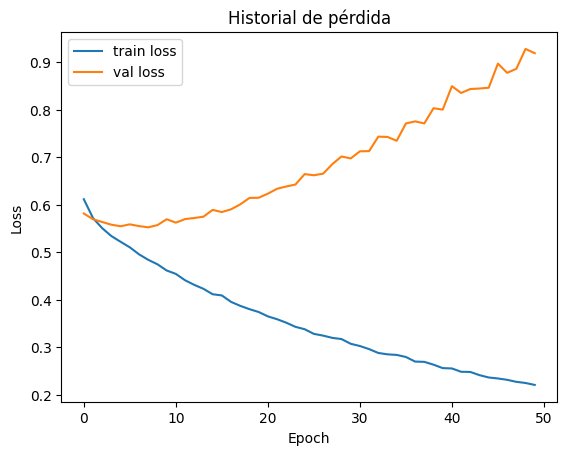

In [61]:
# Pérdida
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Historial de pérdida")
plt.legend(); plt.show()


Predicción

In [62]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int)
y_pred
y_pred.shape

111/111 [==============================] - 1s 3ms/step


(3533, 1)

Metricas

111/111 [==============================] - 0s 3ms/step
Accuracy : 0.6962921030285876
Precision: 0.6908232120053868
Recall   : 0.6962921030285876
F1       : 0.6928553728620959
ROC-AUC  : 0.6581420625727464

Matriz de confusión:
 [[1800  481]
 [ 592  660]]

Reporte de clasificación:
                 precision    recall  f1-score   support

no-recomendado       0.75      0.79      0.77      2281
   recomendado       0.58      0.53      0.55      1252

      accuracy                           0.70      3533
     macro avg       0.67      0.66      0.66      3533
  weighted avg       0.69      0.70      0.69      3533

Especificidad(TNR): 0.7891
Error tipo I (FPR): 0.2109
Error tipo II(FNR): 0.4728


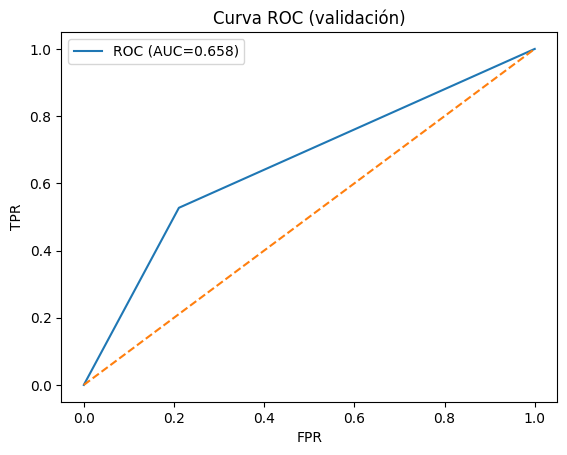

In [63]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int).flatten()
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

acc  = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred, average='weighted', pos_label=1)
rec  = recall_score(y_true,y_pred, pos_label=1,average='weighted')
f1   = f1_score(y_true,y_pred, pos_label=1,average='weighted')
cm   = confusion_matrix(y_true,y_pred)
report = classification_report(y_true,y_pred, target_names=["no-recomendado","recomendado"])

tn, fp, fn, tp = confusion_matrix(y_true,y_pred, labels=[0,1]).ravel()
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0      
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0 
# ROC-AUC (prob de la clase positiva = columna 1)
auc  = roc_auc_score(y_true,y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC-AUC  :", auc)
print("\nMatriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", report)
print(f"Especificidad(TNR): {tnr:.4f}")
print(f"Error tipo I (FPR): {fpr:.4f}")
print(f"Error tipo II(FNR): {fnr:.4f}")

# ===== 5) Curva ROC (opcional en el reporte) =====
fpr, tpr, thr = roc_curve(y_true,y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (validación)")
plt.legend(); plt.show()